In [70]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import norm, skew, boxcox_normmax
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from sklearn import preprocessing 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
#from catboost import Pool
from sklearn.svm import SVR
#from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import KFold, cross_val_score


In [73]:
# Reading csv as a dataframe
data = pd.read_csv('fifa21_male2.csv')
data
# Setting the path to the shapefile
SHAPEFILE = 'map_data/ne_10m_admin_0_countries.shp'

# Read shapefile using Geopandas
geo_df = gpd.read_file(SHAPEFILE)[['ADMIN', 'ADM0_A3', 'geometry']]

CRSError: Invalid projection: epsg:4326: (Internal Proj Error: proj_create: SQLite error on SELECT name, type, coordinate_system_auth_name, coordinate_system_code, datum_auth_name, datum_code, area_of_use_auth_name, area_of_use_code, text_definition, deprecated FROM geodetic_crs WHERE auth_name = ? AND code = ?: no such column: area_of_use_auth_name)

In [3]:
data['POT']

0        69
1        71
2        71
3        82
4        81
         ..
17120    69
17121    66
17122    67
17123    73
17124    74
Name: POT, Length: 17125, dtype: int64

In [4]:
data.info

<bound method DataFrame.info of            ID             Name  Age  OVA            Nationality  \
0           2      G. Pasquale   33   69                  Italy   
1          16      Luis García   37   71                  Spain   
2          27          J. Cole   33   71                England   
3          36         D. Yorke   36   68  Trinidad &amp; Tobago   
4          41          Iniesta   36   81                  Spain   
...       ...              ...  ...  ...                    ...   
17120  259088       A. Medioub   22   64                 France   
17121  259090       W. Rickard   18   56                  Wales   
17122  259091       C. Barrett   18   56                England   
17123  259101   J. Gazibegović   20   62     Bosnia Herzegovina   
17124  259105  Pablo Rodríguez   18   59                  Spain   

                Club  BOV   BP      Position  \
0            Udinese   71  LWB            LM   
1          KAS Eupen   70   CM    CM CAM CDM   
2      Coventry Cit

In [5]:
# Standardization of header names
def standardization(df):
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.replace(' ','_')

In [6]:
standardization(data)
data.columns

Index(['id', 'name', 'age', 'ova', 'nationality', 'club', 'bov', 'bp',
       'position', 'player_photo',
       ...
       'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb', 'gk', 'gender'],
      dtype='object', length=107)

In [7]:
data.isna().sum()

id             0
name           0
age            0
ova            0
nationality    0
              ..
cb             0
rcb            0
rb             0
gk             0
gender         0
Length: 107, dtype: int64

In [8]:
data.dtypes

id              int64
name           object
age             int64
ova             int64
nationality    object
                ...  
cb             object
rcb            object
rb             object
gk             object
gender         object
Length: 107, dtype: object

Rank players by market value.
Highlight the top players for their outstanding performances over a discrete season.
Decide when to transfer a player.
Decide the best replacement for a transferred player.

In [9]:
#Check and deal with NaN values.
def nulls_data(df):
    nulls_df = pd.DataFrame(round(df.isna().sum()/len(df)*100,2))
    nulls_df = nulls_df.reset_index()
    nulls_df.columns = ['header_name', '%_null_values'] 
    return nulls_df

In [10]:
res_nulls = nulls_data(data)
res_nulls

header_name  %_null_values
0             id            0.0
1           name            0.0
2            age            0.0
3            ova            0.0
4    nationality            0.0
..           ...            ...
102           cb            0.0
103          rcb            0.0
104           rb            0.0
105           gk            0.0
106       gender            0.0

[107 rows x 2 columns]

                nan_count           label  Percentage(%)   Keep
positioning             7     positioning       0.040876   True
interceptions           7   interceptions       0.040876   True
club                   23            club       0.134307   True
club_logo              23       club_logo       0.134307   True
sliding_tackle         58  sliding_tackle       0.338686   True
vision                 58          vision       0.338686   True
jumping                58         jumping       0.338686   True
balance                58         balance       0.338686   True
curve                  58           curve       0.338686   True
volleys                58         volleys       0.338686   True
joined                 58          joined       0.338686   True
agility                58         agility       0.338686   True
a/w                    89             a/w       0.519708   True
d/w                    89             d/w       0.519708   True
position              413        positio

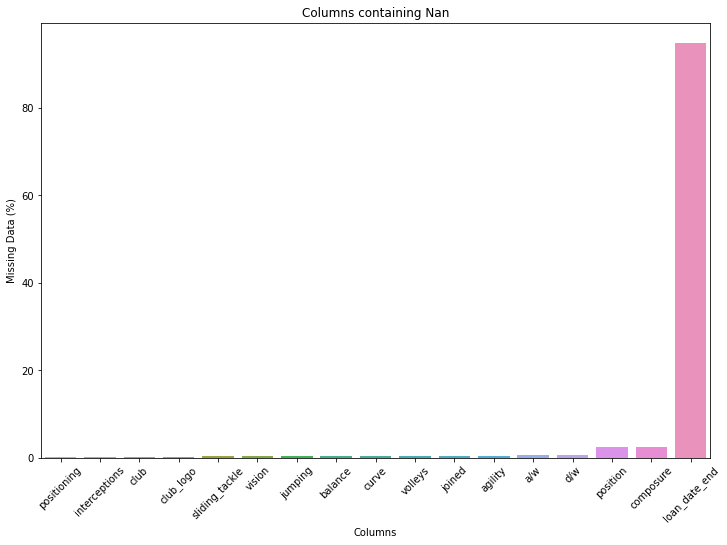

In [11]:
#plotting and looking at the percentage of NAN within the data
nan_info_df = pd.DataFrame(data.isna().sum(), columns=['nan_count'])
nan_info_df['label'] = nan_info_df.index
row_count = len(data.index)
nan_info_df['Percentage(%)'] = (nan_info_df['nan_count'] / row_count) * 100
nan_info_df = nan_info_df[nan_info_df['nan_count'] > 0]
nan_info_df = nan_info_df.sort_values(by=['nan_count'])
nan_info_df['Keep'] = np.where(nan_info_df['Percentage(%)'] > 5, False, True)
print(nan_info_df)

plt.figure(figsize=(12, 8))
sns.barplot(x=nan_info_df['label'], y=nan_info_df['Percentage(%)'])
plt.xticks(rotation=45)
plt.title('Columns containing Nan')
plt.xlabel('Columns')
plt.ylabel('Missing Data (%)')
plt.show()

In [12]:
# finding categorical and numerical columns
data_num = data.select_dtypes(include = np.number)
data_cat = data.select_dtypes(include = np.object)
categorical_columns = data.select_dtypes(include=['object']).columns.tolist()
numerical_columns = data.select_dtypes(exclude=['object']).columns.tolist()
numerical_columns

['id',
 'age',
 'ova',
 'bov',
 'pot',
 'growth',
 'attacking',
 'crossing',
 'finishing',
 'heading_accuracy',
 'short_passing',
 'volleys',
 'skill',
 'dribbling',
 'curve',
 'fk_accuracy',
 'long_passing',
 'ball_control',
 'movement',
 'acceleration',
 'sprint_speed',
 'agility',
 'reactions',
 'balance',
 'power',
 'shot_power',
 'jumping',
 'stamina',
 'strength',
 'long_shots',
 'mentality',
 'aggression',
 'interceptions',
 'positioning',
 'vision',
 'penalties',
 'composure',
 'defending',
 'marking',
 'standing_tackle',
 'sliding_tackle',
 'goalkeeping',
 'gk_diving',
 'gk_handling',
 'gk_kicking',
 'gk_positioning',
 'gk_reflexes',
 'total_stats',
 'base_stats',
 'pac',
 'sho',
 'pas',
 'dri',
 'def',
 'phy']

In [13]:

columns_null =  nan_info_df[nan_info_df['nan_count'] != 0].label
null_numerical = list(set(columns_null) & set(numerical_columns)) # finding numerical columns including null values
null_numerical

['vision',
 'jumping',
 'agility',
 'positioning',
 'composure',
 'sliding_tackle',
 'balance',
 'volleys',
 'curve',
 'interceptions']

In [14]:
# cleaning null values in numerical columns and filling them with mean value of the column

def null_num_fix(df):
    null_numerical = list(set(columns_null) & set(numerical_columns))
    for col in null_numerical:
        df[col] = df[col].replace({np.NaN:df[col].mean()},inplace=True)
    return df 

data = null_num_fix(data)


In [15]:
null_cat = list(set(columns_null) & set(categorical_columns)) # finding categorical columns including null values
null_cat

['position', 'joined', 'a/w', 'd/w', 'club_logo', 'loan_date_end', 'club']

In [16]:
# droping columns with nan values over 5% and some categorical columns which do not include interesting information for the analysis

data = data.drop(['loan_date_end','club_logo','flag_photo','player_photo','joined','id','gender','contract','team_&_contract','hits'],axis=1)
data = data.drop(['ir','ls','st','rs','lw','lf','cf','rf','rw','lam','cam','ram','lm','lcm','cm'],axis=1)
data = data.drop(['rcm','rm','lwb','ldm','cdm','rdm','rwb','lb','lcb','cb','rcb','rb','gk'],axis=1)

In [17]:
# filling missing values of categorical data with the most frequent one
def null_cat_fix(df):
    cols = ['a/w', 'club', 'position','d/w']
    for col in cols:
        df[col] = df[col].fillna(df[col].value_counts().idxmax())
    return df 
data = null_cat_fix(data)

In [18]:
# checking again null values
res_nulls = nulls_data(data)
res_nulls

header_name  %_null_values
0          name            0.0
1           age            0.0
2           ova            0.0
3   nationality            0.0
4          club            0.0
..          ...            ...
64          sho            0.0
65          pas            0.0
66          dri            0.0
67          def            0.0
68          phy            0.0

[69 rows x 2 columns]

In [19]:
# Rank players by market value.
data['value'] # checking value column

0        €625K
1        €600K
2        €1.1M
3           €0
4        €5.5M
         ...  
17120    €550K
17121    €130K
17122    €130K
17123    €475K
17124    €325K
Name: value, Length: 17125, dtype: object

In [20]:
data['release_clause']# this column should be numeric

0           €0
1        €1.1M
2           €0
3           €0
4        €7.2M
         ...  
17120       €0
17121    €273K
17122    €273K
17123    €784K
17124    €788K
Name: release_clause, Length: 17125, dtype: object

In [21]:
# converting the value, wage and release versus euro and removing euro sign
# 'release_clause'
data['convert']=np.where(data['release_clause'].str[-1]=='K',1000,np.where(data['release_clause'].str[-1]=='M',1000000,1)) # converting K to 1000 and M to 1000000
l =['€','K', 'M']
for i in l:
    data['release_clause']=data['release_clause'].str.strip(i) # removing space around '€','K'and 'M'
data['release_clause']=pd.to_numeric(data['release_clause'])# converting it to numeric
data['release_clause']=data['release_clause']*data['convert'] # converting the value of the columns to euro
data['release_clause']

0              0.0
1        1100000.0
2              0.0
3              0.0
4        7200000.0
           ...    
17120          0.0
17121     273000.0
17122     273000.0
17123     784000.0
17124     788000.0
Name: release_clause, Length: 17125, dtype: float64

In [22]:
# 'value'
data['convert']=np.where(data['value'].str[-1]=='K',1000,np.where(data['value'].str[-1]=='M',1000000,1)) # converting K to 1000 and M to 1000000
l =['€','K', 'M']
for i in l:
    data['value']=data['value'].str.strip(i) # removing space around '€', 'K'and 'M'
data['value']=pd.to_numeric(data['value'])# converting it to numeric
data['value']=data['value']*data['convert'] # converting the valueof the columns to euro
data['value']

0         625000.0
1         600000.0
2        1100000.0
3              0.0
4        5500000.0
           ...    
17120     550000.0
17121     130000.0
17122     130000.0
17123     475000.0
17124     325000.0
Name: value, Length: 17125, dtype: float64

In [23]:
# 'wage'
data['convert']=np.where(data['wage'].str[-1]=='K',1000,np.where(data['wage'].str[-1]=='M',1000000,1)) # converting K to 1000 and M to 1000000
l =['€','K', 'M']
for i in l:
    data['wage']=data['wage'].str.strip(i) # removing space around '€', 'K'and 'M'
data['wage']=pd.to_numeric(data['wage'])# converting it to numeric
data['wage']=data['wage']*data['convert'] # converting the value of the columns to euro
data['wage']
data = data.drop(['convert'],axis=1)
data['wage']

0         7000
1         7000
2        15000
3            0
4        12000
         ...  
17120     2000
17121     3000
17122     2000
17123     3000
17124     2000
Name: wage, Length: 17125, dtype: int64

In [24]:
# correcting and cleaning height, weight, sm and w/f
data['height'].dtypes

dtype('O')

In [25]:
data['weight'].dtypes

dtype('O')

In [26]:
data['sm']

0        2★
1        3★
2        4★
3        1★
4        4★
         ..
17120    2★
17121    2★
17122    2★
17123    2★
17124    3★
Name: sm, Length: 17125, dtype: object

In [27]:
data['w/f']

0        3 ★
1        4 ★
2        4 ★
3        3 ★
4        4 ★
        ... 
17120    2 ★
17121    3 ★
17122    3 ★
17123    4 ★
17124    3 ★
Name: w/f, Length: 17125, dtype: object

In [28]:
# some symbols should be removed from height, weight, sm and w/f and they are converted to SI
def fix(x):
    
        x = x.replace("'",".")
        x = x.replace('"',"")
    
        x=x.replace("lbs",'')
        # W/F and SM
        x=x.replace("★",'')
        if ((".") in x):
            x = x.split(".")
            x = round((int(x[0])*12+int(x[1])) * 2.54, 1)
        return int(x)

In [29]:
def fix(x):
    dictionary = {"'":".", '"':"","lbs":'', "★":'' } 
    for key in dictionary.keys():
        x = x.replace(key, dictionary[key])
    return x
    if ((".") in x):
        x = x.split(".")
        x = round((int(x[0])*12+int(x[1])) * 2.54, 1)
    return float(x)

In [30]:

data['height'] = data['height'].apply(fix)
data['w/f'] = data['w/f'].apply(fix)
data['sm'] = data['sm'].apply(fix)                  

In [31]:
data['height']

0         6.0
1        5.10
2         5.9
3        5.11
4         5.7
         ... 
17120     6.6
17121    5.10
17122     5.9
17123     5.9
17124    5.10
Name: height, Length: 17125, dtype: object

In [32]:
data['weight'] = data['weight'].apply(fix).astype(int)*0.453592 # converting weight to kg from lbs
data['weight']

0        82.100152
1        64.863656
2        73.028312
3        74.842680
4        68.038800
           ...    
17120    74.842680
17121    77.110640
17122    69.853168
17123    67.131616
17124    69.853168
Name: weight, Length: 17125, dtype: float64

In [33]:
data['sm']

0        2
1        3
2        4
3        1
4        4
        ..
17120    2
17121    2
17122    2
17123    2
17124    3
Name: sm, Length: 17125, dtype: object

<AxesSubplot:>

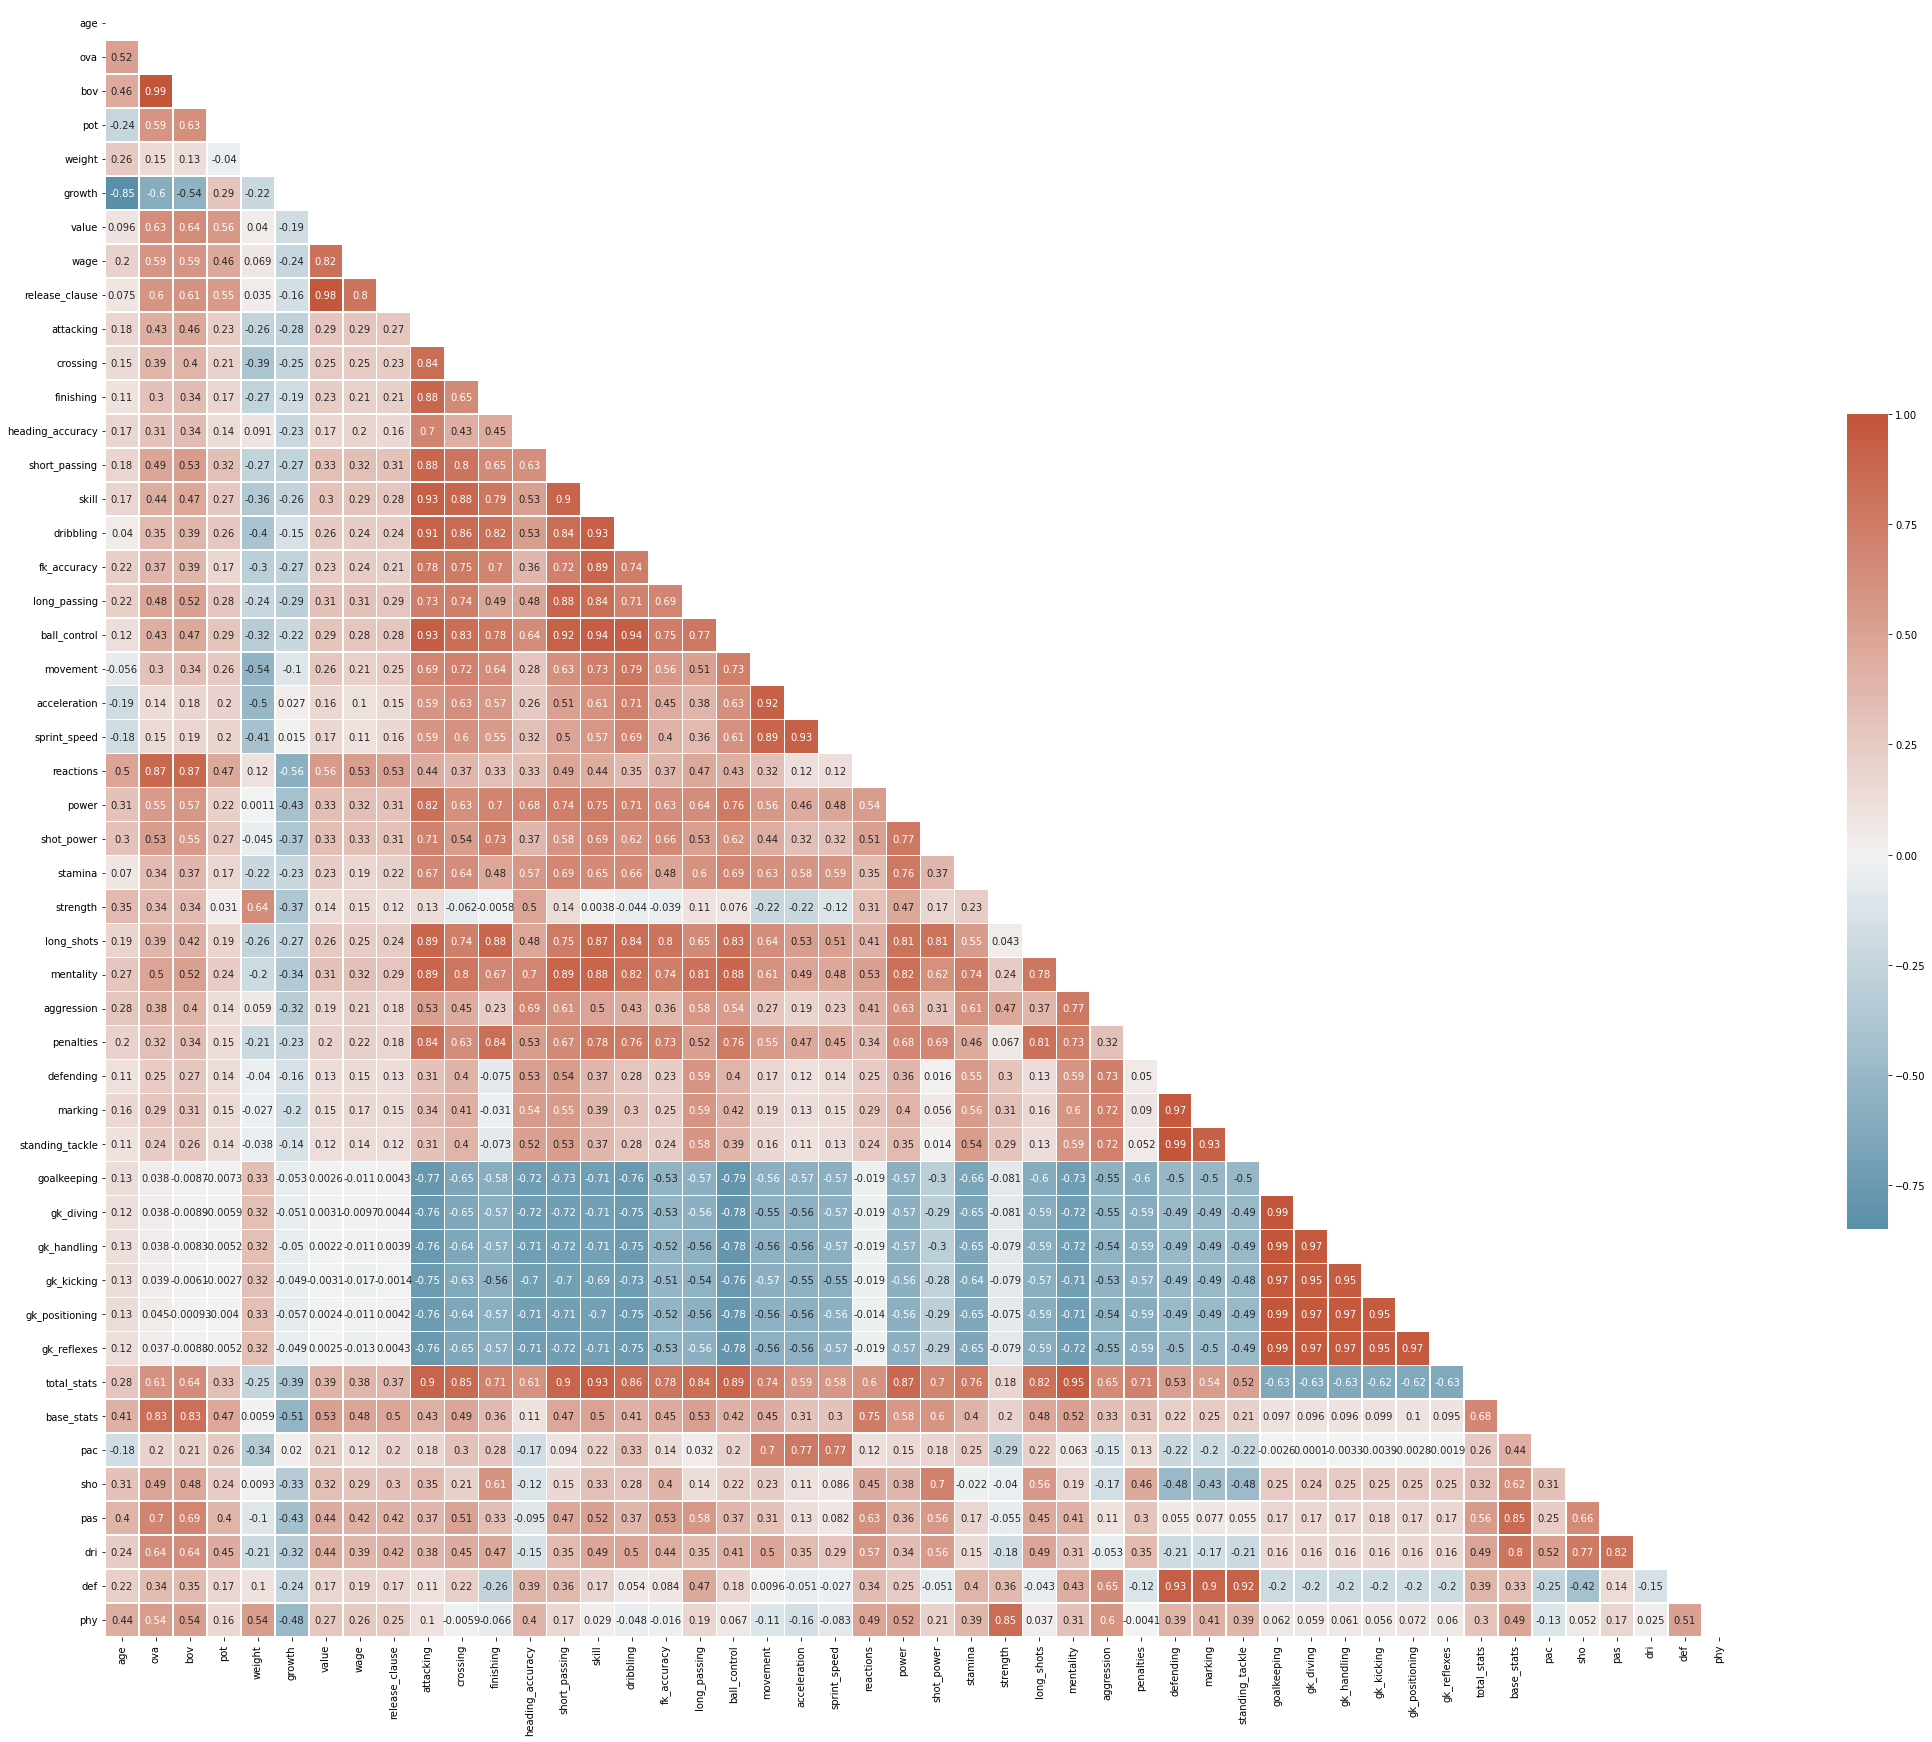

In [34]:
f, ax = plt.subplots(figsize=(40, 30))
mat = data.corr('pearson')
mask = np.triu(np.ones_like(mat, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(mat, mask=mask, cmap=cmap, vmax=1, center=0, annot = True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [35]:
# the goal of this project is predicting potential of the soccerplayers as a target value, so some other features with correlation less than 0.2 with the target are dropped
data = data.drop(['phy','def','gk_reflexes','gk_positioning','gk_kicking','gk_handling','gk_diving','goalkeeping','standing_tackle','marking','defending','penalties',
                   'aggression','long_shots','strength','stamina','fk_accuracy','heading_accuracy','finishing','height','weight'], axis=1)

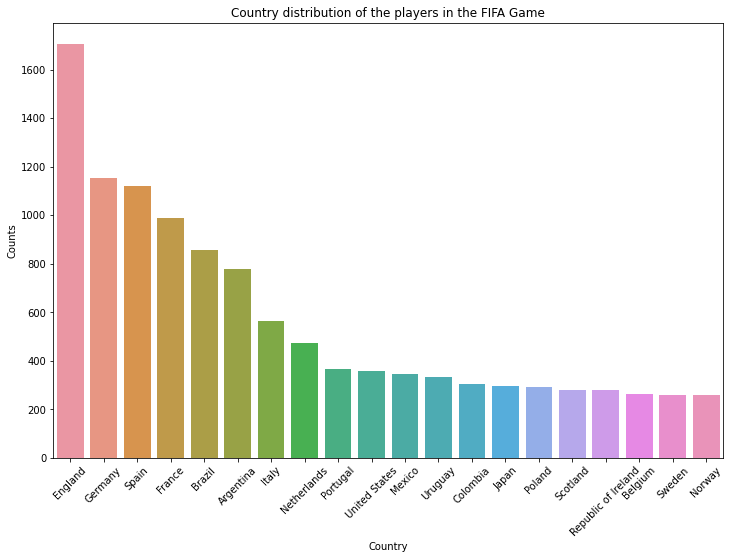

In [36]:
# visualising country distribution of players 
data_nation = data.groupby('nationality').apply(lambda x:x['name'].count()).reset_index(name='Counts')
data_nation.sort_values(by ='Counts',ascending=False,inplace=True)
top_10_nation_c = data_nation[:20] # top 10 countries with highest players
plt.figure(figsize=(12, 8))
sns.barplot(x=top_10_nation_c['nationality'],y=top_10_nation_c['Counts'])
plt.xticks(rotation=45)
plt.title('Country distribution of the players in the FIFA Game')
plt.xlabel('Country')
plt.ylabel('Counts')
plt.show()


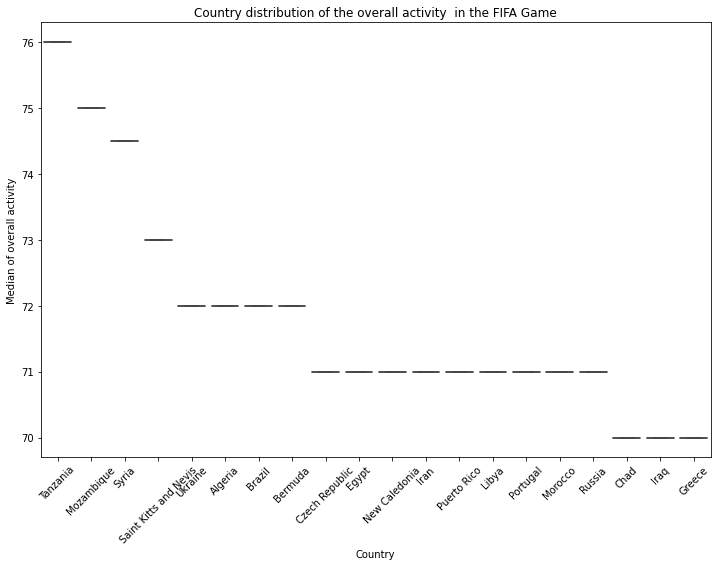

In [50]:
# visualising country distribution of overall activity 
data_nation = data.groupby('nationality',as_index=False)['ova'].median()
data_nation.sort_values(by ='ova',ascending=False,inplace=True)
top_10_nation_ova = data_nation[:20] # top 20 countries with highest players
plt.figure(figsize=(12, 8))
sns.boxplot(x=top_10_nation_ova['nationality'],y=top_10_nation_ova['ova'])
plt.xticks(rotation=45)
plt.title('Country distribution of the overall activity  in the FIFA Game')
plt.xlabel('Country')
plt.ylabel('Median of overall activity')
plt.show()

In [38]:
data_nation = data.groupby('nationality',as_index=False)['ova'].median()
data_nation.sort_values(by ='ova',ascending=False,inplace=True)
data_nation

nationality   ova
150               Tanzania  76.0
106             Mozambique  75.0
148                  Syria  74.5
131  Saint Kitts and Nevis  73.0
157                Ukraine  72.0
..                     ...   ...
21       Brunei Darussalam  57.0
73               Indonesia  56.0
111              Nicaragua  56.0
112                  Niger  54.5
69               Hong Kong  52.5

[167 rows x 2 columns]

In [39]:
data['wage']

0         7000
1         7000
2        15000
3            0
4        12000
         ...  
17120     2000
17121     3000
17122     2000
17123     3000
17124     2000
Name: wage, Length: 17125, dtype: int64

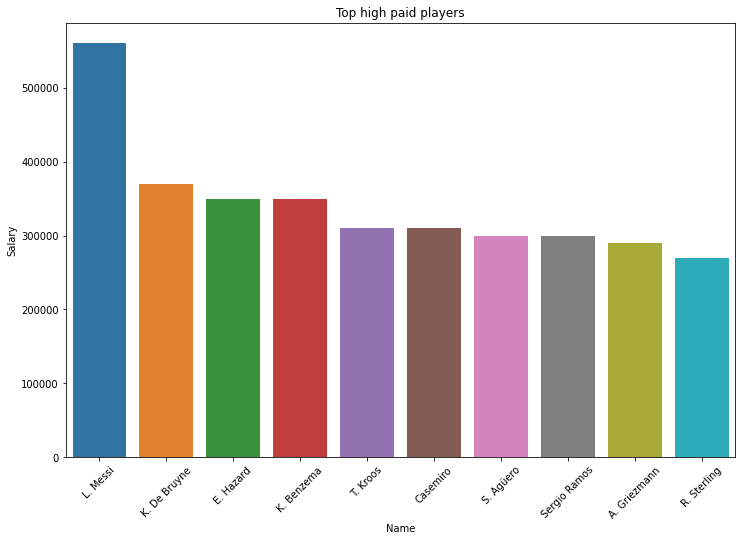

In [40]:
data_salary= data[['name','wage']]
# visualising the salary of the players
data_salary.sort_values(by ='wage',ascending=False,inplace=True)
top_20 = data_salary[:10] # top 10 people with the highest salary
plt.figure(figsize=(12, 8))
sns.barplot(x=top_20['name'],y=top_20['wage'])
plt.xticks(rotation=45)
plt.title('Top high paid players')
plt.xlabel('Name')
plt.ylabel('Salary')
plt.show()

In [41]:
data.shape

(17125, 48)

In [42]:
# growth is dropped
data = data.drop(['growth'], axis=1)

In [43]:
# having a dataFrame with our desired columns
market_value=data[['name','club','value']] 

# Rank players by market value.
market_value['rank'] = market_value['value'].rank(ascending=False)
market_value

name           club      value     rank
0          G. Pasquale        Udinese   625000.0  10095.0
1          Luis García      KAS Eupen   600000.0  10325.5
2              J. Cole  Coventry City  1100000.0   6717.5
3             D. Yorke     Sunderland        0.0  16897.0
4              Iniesta    Vissel Kobe  5500000.0   2187.0
...                ...            ...        ...      ...
17120       A. Medioub     CD Tondela   550000.0  10828.0
17121       W. Rickard        Burnley   130000.0  15804.0
17122       C. Barrett        Burnley   130000.0  15804.0
17123   J. Gazibegović  SK Sturm Graz   475000.0  11647.5
17124  Pablo Rodríguez          Lecce   325000.0  13399.5

[17125 rows x 4 columns]

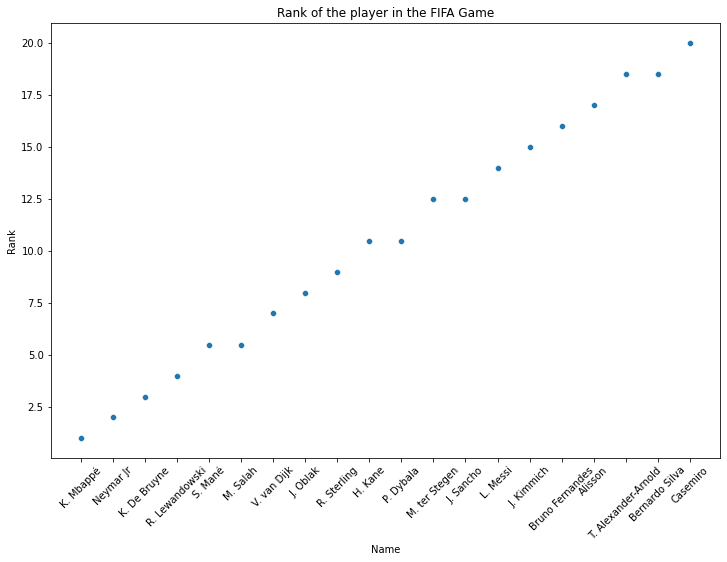

In [44]:
# visualising the rank players by market value.
market_value.sort_values(by ='rank',ascending=True,inplace=True)
top_20 = market_value[:20] # top 20 countries with highest players
plt.figure(figsize=(12, 8))
sns.scatterplot(x=top_20['name'],y=top_20['rank'])
plt.xticks(rotation=45)
plt.title('Rank of the player in the FIFA Game')
plt.xlabel('Name')
plt.ylabel('Rank')
plt.show()

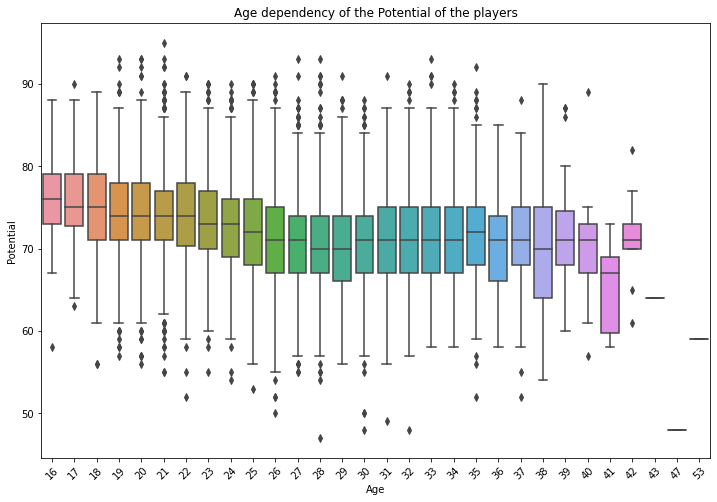

In [47]:
# visualising the potential players by age.
potential_age = data[['age','pot']]
potential_age.sort_values(by ='pot',ascending=False,inplace=True)

plt.figure(figsize=(12, 8))
sns.boxplot(x=potential_age['age'],y=potential_age['pot'])
plt.xticks(rotation=45)
plt.title('Age dependency of the Potential of the players')
plt.xlabel('Age')
plt.ylabel('Potential')
plt.show()

In [51]:
# Fixing skewness of numerical features using log_transformation
data_num = data.select_dtypes(include = np.number)
skewed_features = data_num.apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_features})
high_skew = skewed_features[skewed_features > 0.5]
skew_index = high_skew.index
high_skew

wage              6.535425
release_clause    6.363726
value             6.267479
dtype: float64

In [52]:
for i in skew_index:
    data_num[i] = np.log1p(data_num[i])
data_num

age  ova  bov  pot      value      wage  release_clause  attacking  \
0       33   69   71   69  13.345509  8.853808        0.000000        313   
1       37   71   70   71  13.304687  8.853808       13.910822        337   
2       33   71   71   71  13.910822  9.615872        0.000000        337   
3       36   68   70   82   0.000000  0.000000        0.000000        264   
4       36   81   82   81  15.520259  9.392745       15.789592        367   
...    ...  ...  ...  ...        ...       ...             ...        ...   
17120   22   64   66   69  13.217675  7.601402        0.000000        197   
17121   18   56   58   66  11.775297  8.006701       12.517231        248   
17122   18   56   56   67  11.775297  7.601402       12.517231        218   
17123   20   62   62   73  13.071072  8.006701       13.572166        223   
17124   18   59   61   74  12.691584  7.601402       13.577255        254   

       crossing  short_passing  skill  dribbling  long_passing  ball_control  \
0            75             71    338         73            69            71   
1            68             76    369         69            71            71   
2            80             77    387         79            69            78   
3            54             80    255         68            64            77   
4            75             90    408         85            83            90   
...         ...            ...    ...        ...           ...           ...   
17120        35             47    193         44            34            56   
17121        50             64    264         57            61            54   
17122        55             42    212         52            36            47   
17123        62             60    258         55            57            57   
17124        32             45    235         57            30            55   

       movement  acceleration  sprint_speed  reactions  power  shot_power  \
0           347            68            74         69    347          74   
1           305            56            50         65    324          75   
2           295            48            42         59    284          72   
3           176            59            62         55    239          63   
4           346            61            56         75    297          67   
...         ...           ...           ...        ...    ...         ...   
17120       243            52            55         48    279          48   
17121       298            61            63         54    271          51   
17122       308            66            61         59    233          28   
17123       349            72            70         56    261          51   
17124       317            68            72         53    288          58   

       mentality  total_stats  base_stats  pac  sho  pas  dri  
0            320         1929         408   71   59   70   71  
1            362         1906         385   53   69   73   69  
2            317         1770         354   45   68   76   77  
3            271         1348         369   61   66   66   69  
4            370         2014         420   58   70   85   85  
...          ...          ...         ...  ...  ...  ...  ...  
17120        218         1367         302   54   30   37   48  
17121        259         1529         319   62   46   57   56  
17122        256         1430         303   63   35   44   52  
17123        257         1579         335   71   34   58   59  
17124        224         1401         295   70   62   41   57  

[17125 rows x 27 columns]

In [53]:
data_num.rename(columns={'wage': 'wage_log', 'value': 'value_log','release_clause':'release_clause_log'}, inplace = True)

In [54]:
data['wage'] = data_num['wage_log']
data['value'] = data_num['value_log']
data['release_clause'] = data_num['release_clause_log']
data.rename(columns={'wage': 'wage_log', 'value': 'value_log','release_clause':'release_clause_log'}, inplace = True)

<AxesSubplot:>

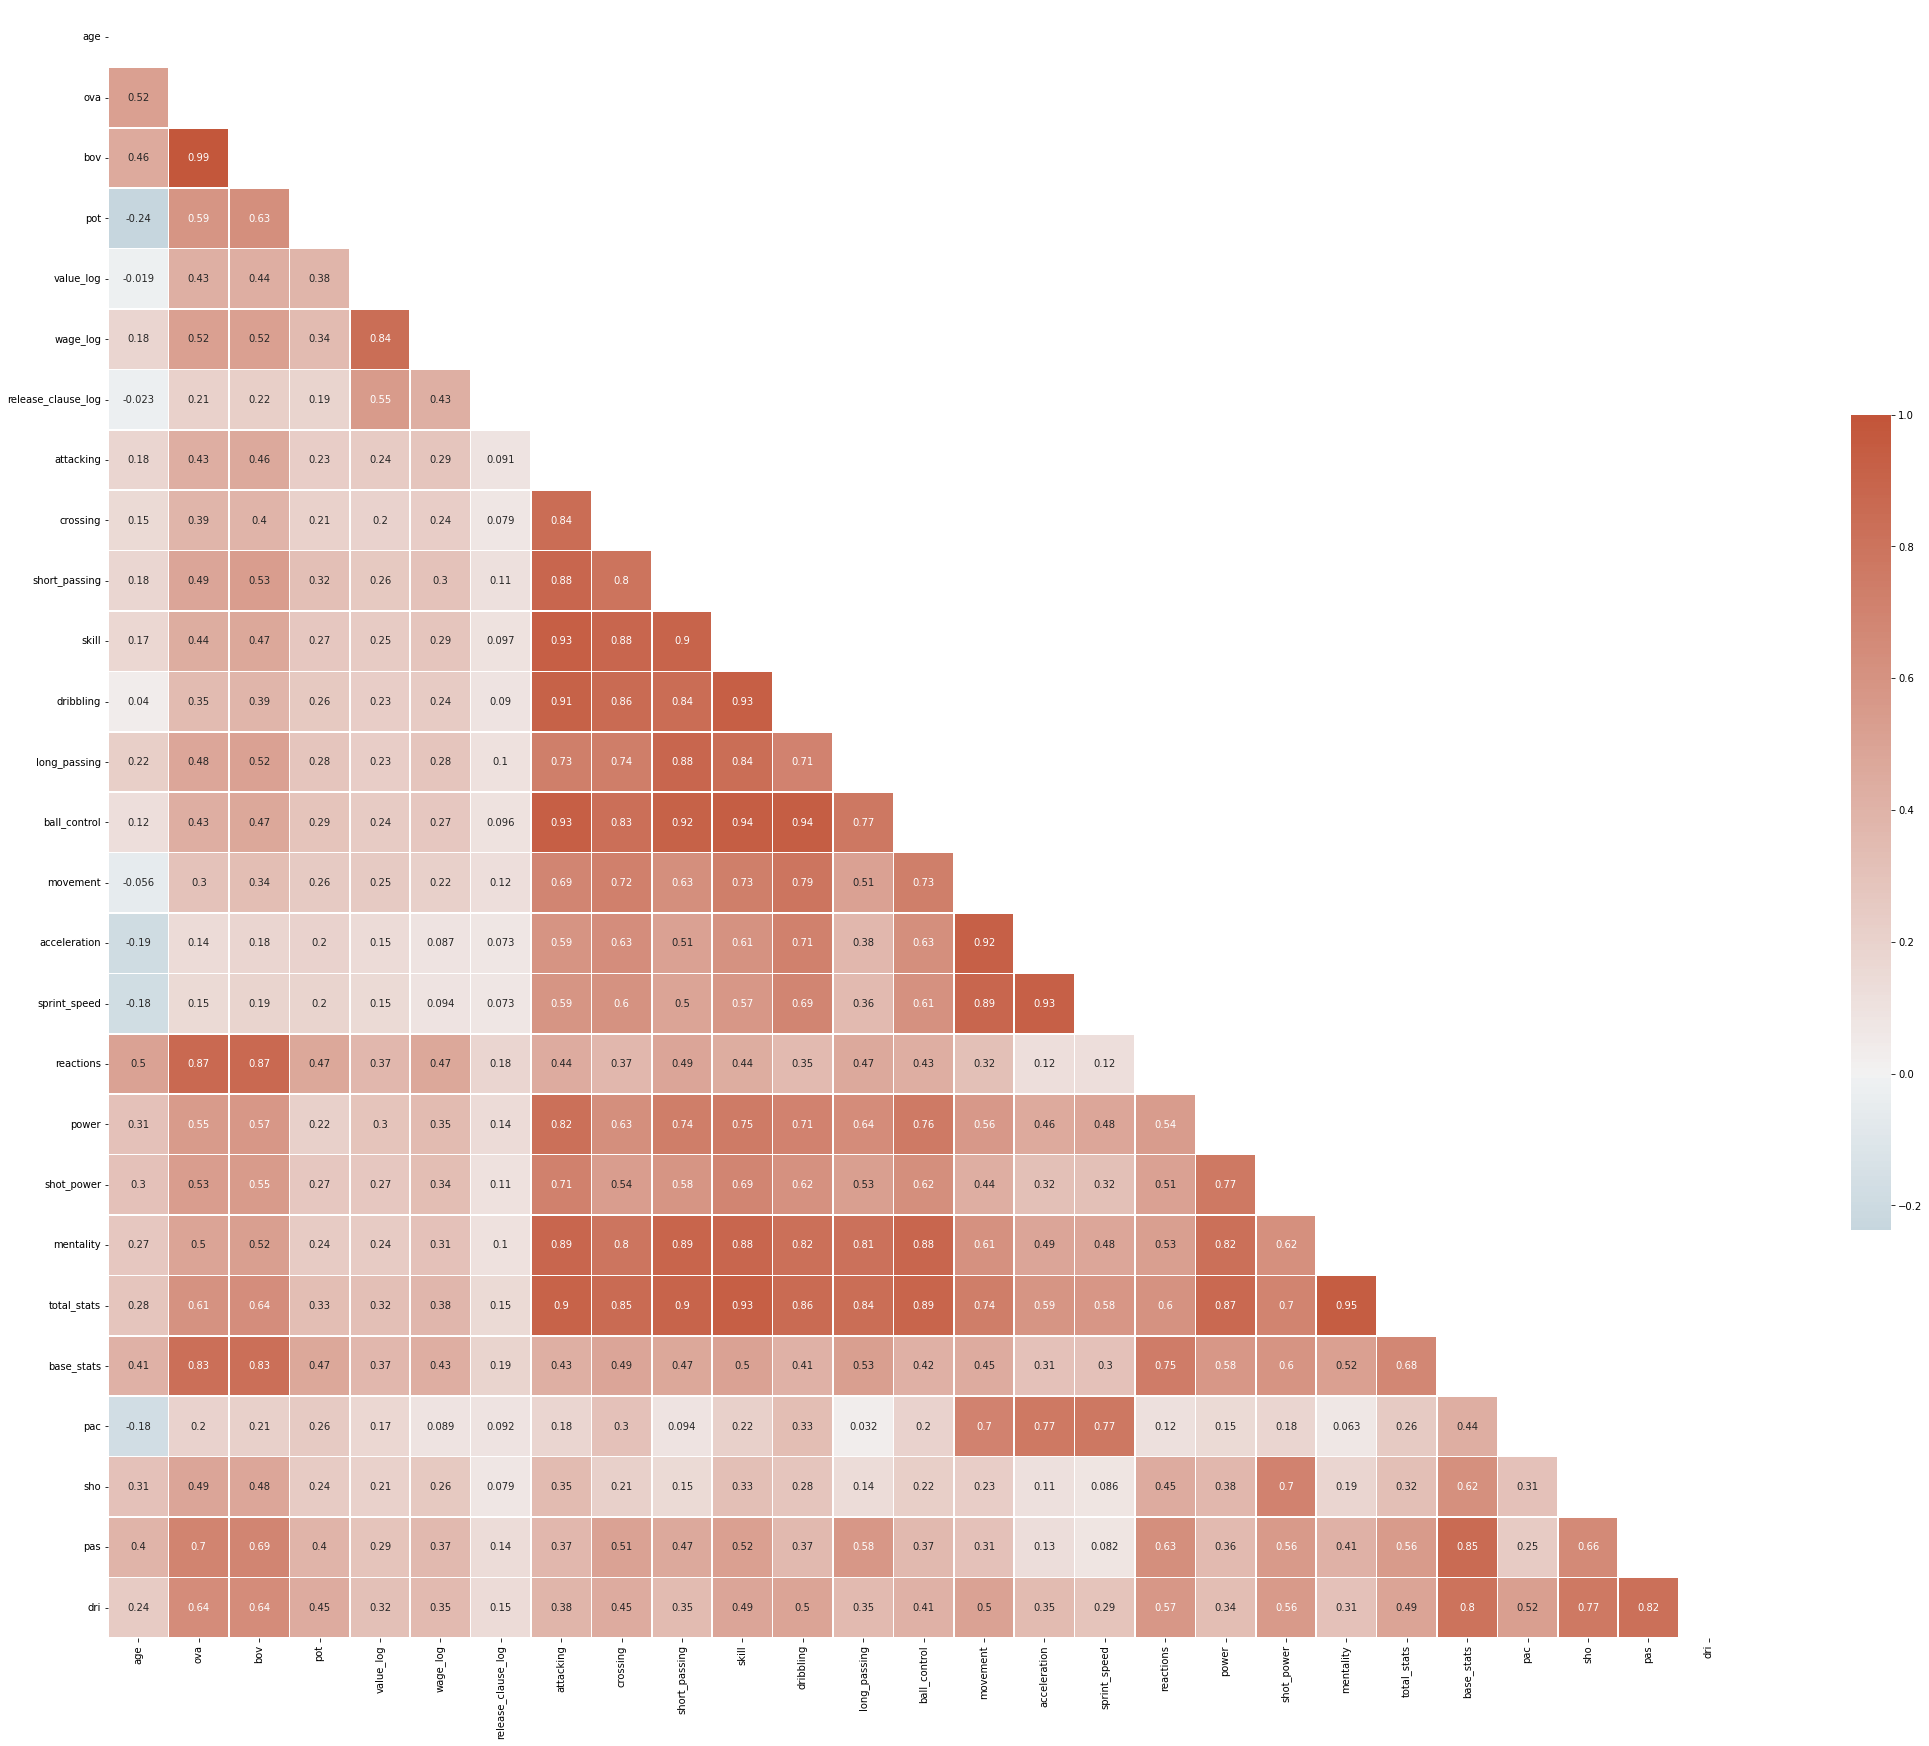

In [55]:
# checking again heatmap after dropping some columns
f, ax = plt.subplots(figsize=(40, 30))
mat = data.corr('pearson')
mask = np.triu(np.ones_like(mat, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(mat, mask=mask, cmap=cmap, vmax=1, center=0, annot = True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [56]:
data=data.drop(['total_stats','base_stats','long_passing','ball_control','short_passing'],axis=1)

In [57]:
data.shape

(17125, 42)

# Checking the data by visualization, especially checking for multicollinearity
sns.pairplot(data)

In [58]:
data['position']

0                  LM
1          CM CAM CDM
2        CAM RM RW LM
3                  CB
4              CM CAM
             ...     
17120              CB
17121          CAM CM
17122              RB
17123           RB LB
17124              ST
Name: position, Length: 17125, dtype: object

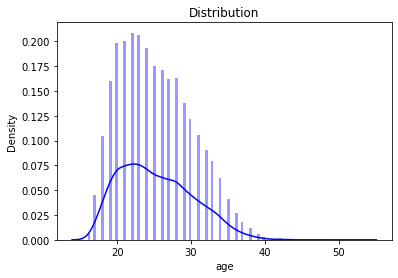

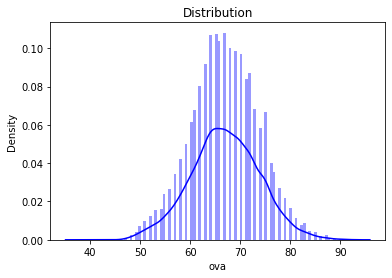

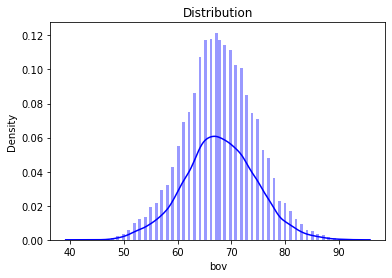

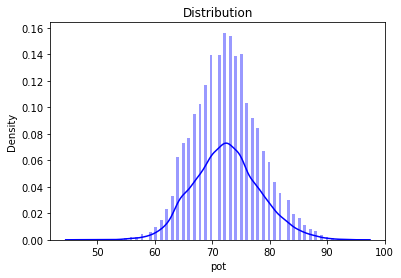

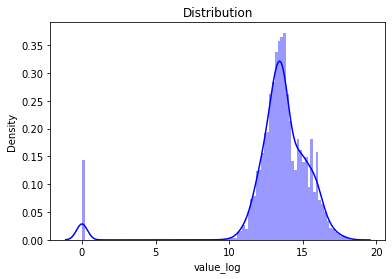

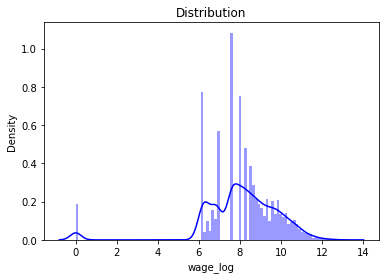

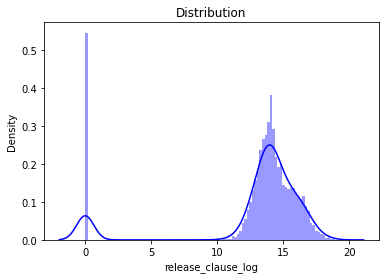

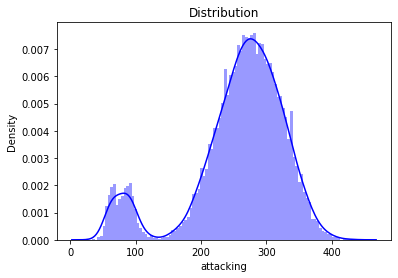

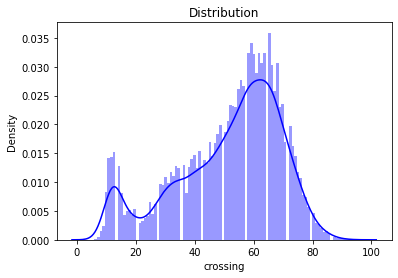

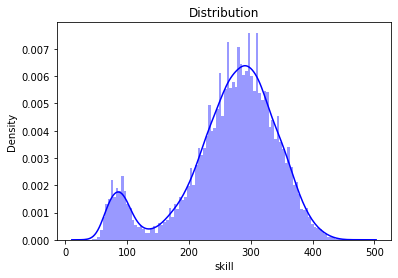

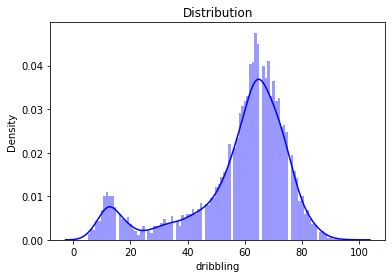

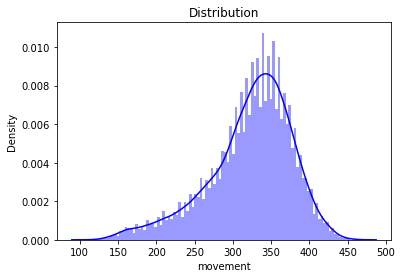

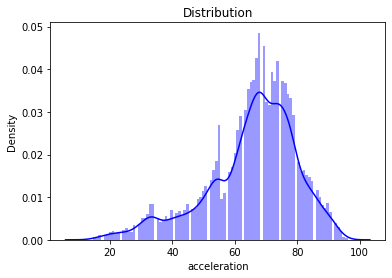

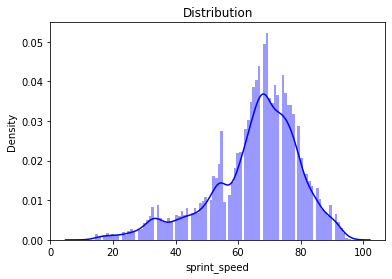

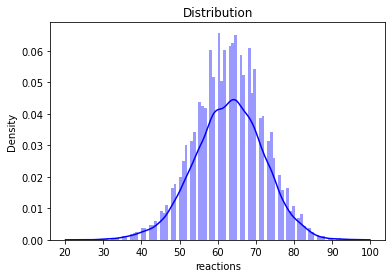

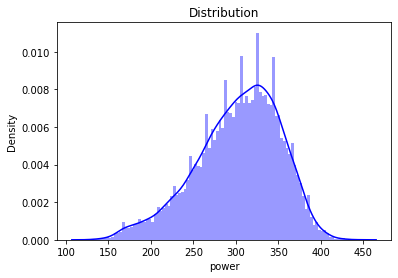

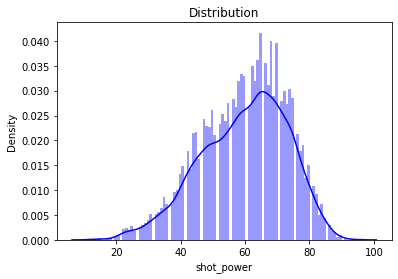

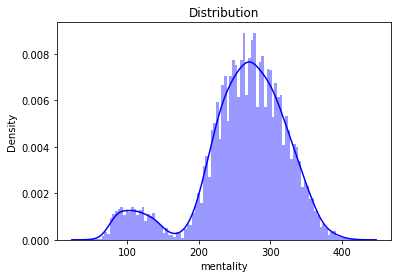

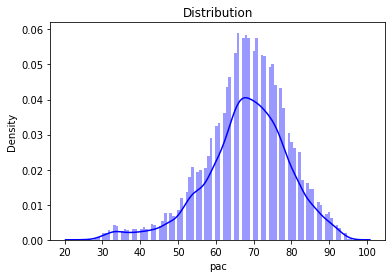

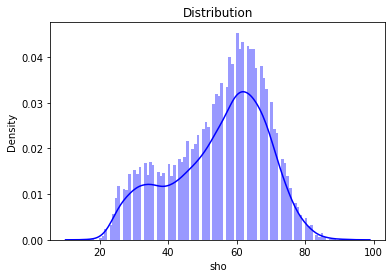

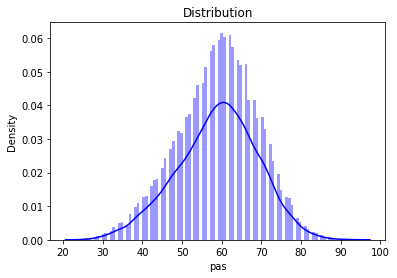

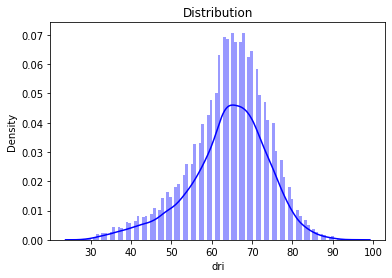

In [59]:
data_num = data.select_dtypes(include = np.number)
data_cat = data.select_dtypes(include = np.object)
categorical_columns = data.select_dtypes(include=['object']).columns.tolist()
numerical_columns = data.select_dtypes(exclude=['object']).columns.tolist()
numerical_columns
#Now we will try to check the normality of the numerical variables visually
#seaborn library is used to construct distribution plots for the numerical variables
for col in numerical_columns:
    sns.distplot(data_num[col],bins= 100, 
                   color = 'blue')
    plt.title('Distribution')
    plt.show()

In [60]:
data=data.drop(['name'],axis=1)

In [61]:
fifa = data[['value_log','age','bov','release_clause_log','ova','attacking','movement','power','mentality',
              'dribbling','wage_log','reactions','crossing','pot','sho']]

In [62]:
# Encoding nominal categorical variables 
fifa=pd.get_dummies(fifa,drop_first=True)
fifa

value_log  age  bov  release_clause_log  ova  attacking  movement  \
0      13.345509   33   71            0.000000   69        313       347   
1      13.304687   37   70           13.910822   71        337       305   
2      13.910822   33   71            0.000000   71        337       295   
3       0.000000   36   70            0.000000   68        264       176   
4      15.520259   36   82           15.789592   81        367       346   
...          ...  ...  ...                 ...  ...        ...       ...   
17120  13.217675   22   66            0.000000   64        197       243   
17121  11.775297   18   58           12.517231   56        248       298   
17122  11.775297   18   56           12.517231   56        218       308   
17123  13.071072   20   62           13.572166   62        223       349   
17124  12.691584   18   61           13.577255   59        254       317   

       power  mentality  dribbling  wage_log  reactions  crossing  pot  sho  
0        347        320         73  8.853808         69        75   69   59  
1        324        362         69  8.853808         65        68   71   69  
2        284        317         79  9.615872         59        80   71   68  
3        239        271         68  0.000000         55        54   82   66  
4        297        370         85  9.392745         75        75   81   70  
...      ...        ...        ...       ...        ...       ...  ...  ...  
17120    279        218         44  7.601402         48        35   69   30  
17121    271        259         57  8.006701         54        50   66   46  
17122    233        256         52  7.601402         59        55   67   35  
17123    261        257         55  8.006701         56        62   73   34  
17124    288        224         57  7.601402         53        32   74   62  

[17125 rows x 15 columns]

In [63]:
# normalization of the data
transformer = StandardScaler().fit(fifa)
fifa = transformer.transform(fifa)
fifa

array([[-0.03507841,  1.5633855 ,  0.46702351, ...,  1.30788441,
        -0.60484284,  0.29059902],
       [-0.05080394,  2.37268908,  0.31636083, ...,  0.91628024,
        -0.25820918,  1.01120548],
       [ 0.18269305,  1.5633855 ,  0.46702351, ...,  1.58760167,
        -0.25820918,  0.93914483],
       ...,
       [-0.63995941, -1.47150296, -1.79291667, ...,  0.18901537,
        -0.95147649, -1.43885648],
       [-0.14079752, -1.06685116, -0.8889406 , ...,  0.58061953,
         0.08842447, -1.51091712],
       [-0.28698518, -1.47150296, -1.03960328, ..., -1.09768403,
         0.2617413 ,  0.50678096]])

In [64]:
fifa= pd.DataFrame(fifa, columns =['value_log','age','bov','release_clause_log','ova','attacking','movement','power','mentality',
                'dribbling','wage_log','reactions','crossing','pot','sho'])
fifa

value_log       age       bov  release_clause_log       ova  attacking  \
0      -0.035078  1.563385  0.467024           -2.812030  0.296466   0.753765   
1      -0.050804  2.372689  0.316361            0.215719  0.587835   1.085929   
2       0.182693  1.563385  0.467024           -2.812030  0.587835   1.085929   
3      -5.176072  2.170363  0.316361           -2.812030  0.150781   0.075598   
4       0.802685  2.170363  2.124313            0.624641  2.044685   1.501133   
...          ...       ...       ...                 ...       ...        ...   
17120  -0.084323 -0.662199 -0.286290           -2.812030 -0.431959  -0.851691   
17121  -0.639959 -1.471503 -1.491591           -0.087602 -1.597438  -0.145844   
17122  -0.639959 -1.471503 -1.792917           -0.087602 -1.597438  -0.561048   
17123  -0.140798 -1.066851 -0.888941            0.142009 -0.723329  -0.491848   
17124  -0.286985 -1.471503 -1.039603            0.143117 -1.160383  -0.062803   

       movement     power  mentality  dribbling  wage_log  reactions  \
0      0.442481  0.902916   0.923148   0.839686  0.400712   0.672252   
1     -0.322101  0.437133   1.590746   0.618039  0.400712   0.229628   
2     -0.504145 -0.372926   0.875463   1.172156  0.807074  -0.434308   
3     -2.670460 -1.284242   0.144284   0.562627 -4.320475  -0.876932   
4      0.424276 -0.109657   1.717908   1.504626  0.688094   1.336188   
...         ...       ...        ...        ...       ...        ...   
17120 -1.450770 -0.474184  -0.698161  -0.767254 -0.267118  -1.651524   
17121 -0.449532 -0.636195  -0.046459  -0.046902 -0.050998  -0.987588   
17122 -0.267488 -1.405751  -0.094144  -0.323960 -0.267118  -0.434308   
17123  0.478889 -0.838710  -0.078249  -0.157725 -0.050998  -0.766276   
17124 -0.103649 -0.291920  -0.602790  -0.046902 -0.267118  -1.098244   

       crossing       pot       sho  
0      1.307884 -0.604843  0.290599  
1      0.916280 -0.258209  1.011205  
2      1.587602 -0.258209  0.939145  
3      0.133072  1.648276  0.795024  
4      1.307884  1.474959  1.083266  
...         ...       ...       ...  
17120 -0.929854 -0.604843 -1.799160  
17121 -0.090702 -1.124793 -0.646189  
17122  0.189015 -0.951476 -1.438856  
17123  0.580620  0.088424 -1.510917  
17124 -1.097684  0.261741  0.506781  

[17125 rows x 15 columns]

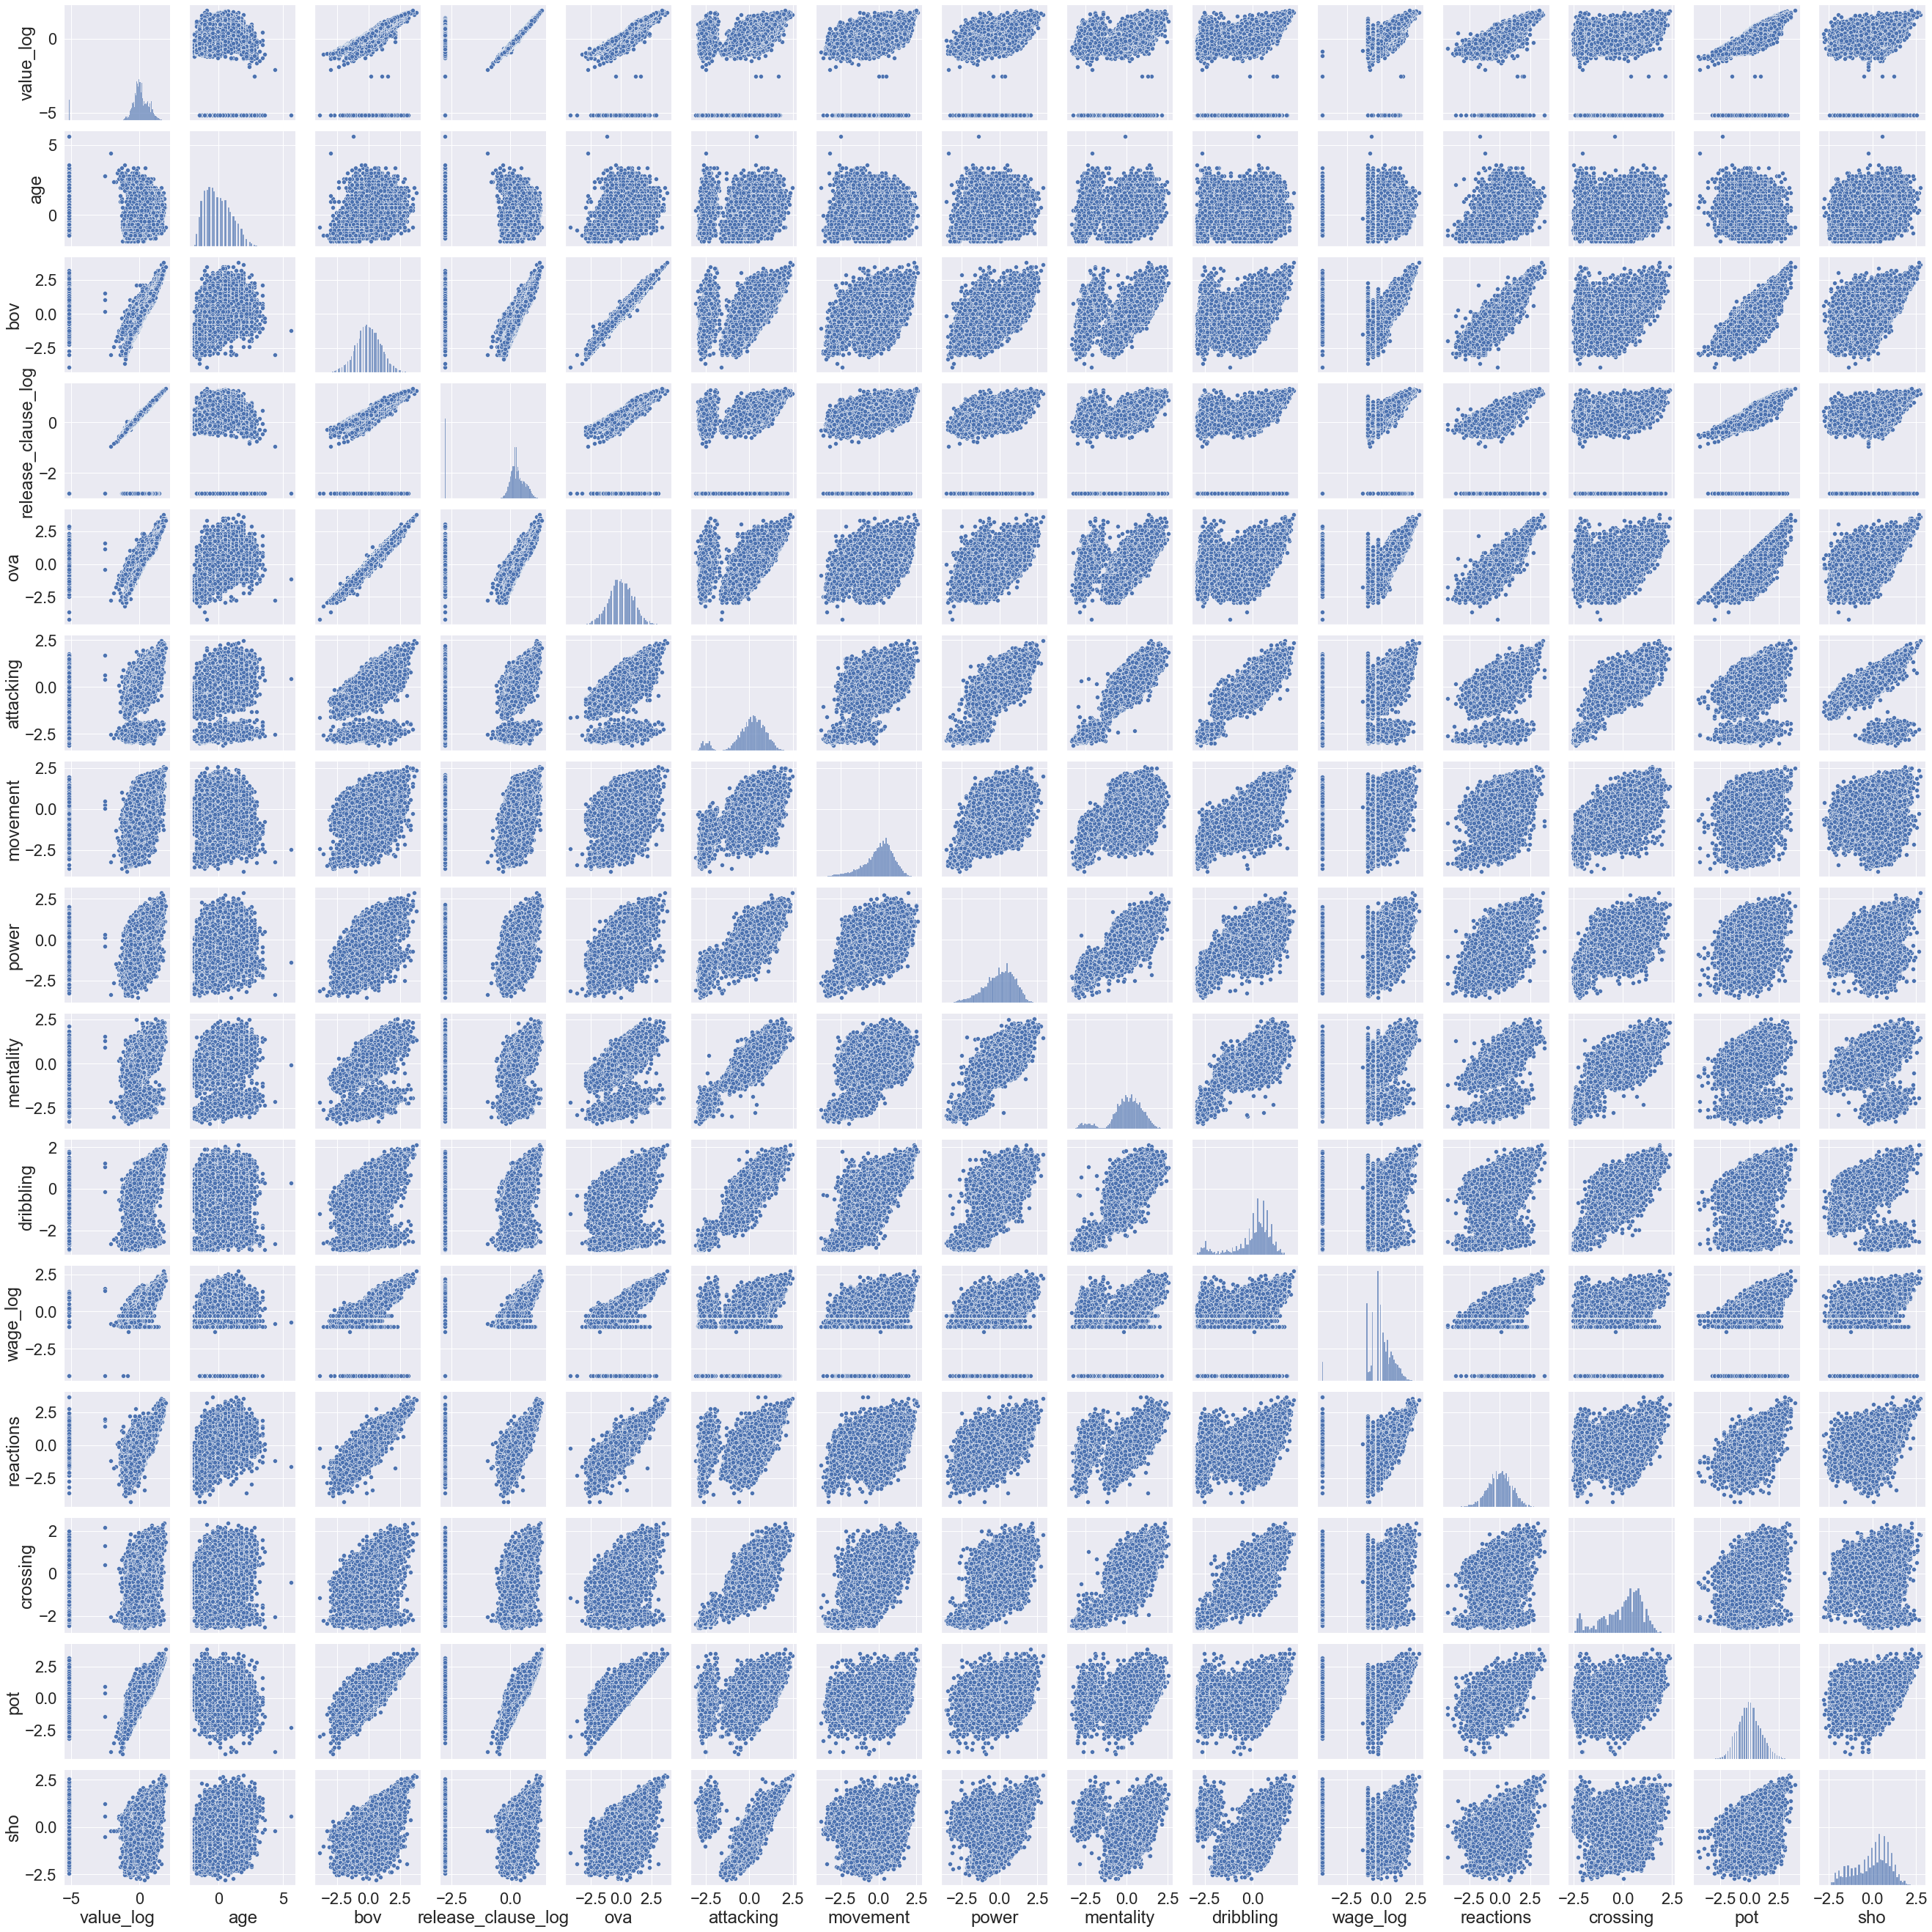

In [76]:
sns.pairplot(fifa)

In [65]:
fifa= pd.DataFrame(fifa)
y = fifa['pot']

x = fifa.drop(['pot'], axis=1)


In [66]:
# splitting data to training and test sets
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size= 0.20, random_state=100)

In [ ]:
# Features' importance of our model
rfr = RandomForestRegressor(n_estimators=100)
rfr_model = rfr.fit(x_train, y_train)
feat_imp = rfr_model.feature_importances_

feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(x.columns, feat_imp):
    feats[feature] = importance #add the name/value pair

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'importance'})


importances = importances.sort_values(['importance'], ascending=[False]).iloc[:20]
importances.plot(kind='bar', rot=47, figsize=(12,7), color='orange', edgecolor='black', alpha=0.8, fontsize=15)
plt.ylabel('Random Forest feature importance', fontsize = 20)
importances.set_xticklabels(fontsize=20)
#plt.legend(['Random Forest feature importance'], loc='best', fontsize=12)


In [67]:
# Metric
def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model):
    rmse = np.sqrt(-cross_val_score(model, x, y, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

# 10 Fold Cross validation

kf = KFold(n_splits=10, random_state=42, shuffle=True)

cv_scores = []
cv_std = []

In [68]:
# 10 Fold Cross validation

kf = KFold(n_splits=10, random_state=42, shuffle=True)

cv_scores = []
cv_std = []

models = ['Linear_Reg.','Bayesian_Ridge_Reg.','SVR','Dec.Tree.Reg.','Random_Forest_Reg.','Grad_Bosst_Reg.']

# Linear Regression

lreg = LinearRegression()
score_lreg = cv_rmse(lreg)
cv_scores.append(score_lreg.mean())
cv_std.append(score_lreg.std())

# Bayesian Ridge Regression

brr = BayesianRidge(compute_score=True)
score_brr = cv_rmse(brr)
cv_scores.append(score_brr.mean())
cv_std.append(score_brr.std())


# Support Vector Regression

svr = SVR()
score_svr = cv_rmse(svr)
cv_scores.append(score_svr.mean())
cv_std.append(score_svr.std())

# Decision Tree Regressor

dtr = DecisionTreeRegressor()
score_dtr = cv_rmse(dtr)
cv_scores.append(score_dtr.mean())
cv_std.append(score_dtr.std())

# Random Forest Regressor

rfr = RandomForestRegressor()
score_rfr = cv_rmse(rfr)
cv_scores.append(score_rfr.mean())
cv_std.append(score_rfr.std())



# Gradient Boost Regressor

gbr = GradientBoostingRegressor()
score_gbr = cv_rmse(gbr)
cv_scores.append(score_gbr.mean())
cv_std.append(score_gbr.std())


final_cv_score = pd.DataFrame(models, columns = ['Regressors'])
final_cv_score['RMSE_mean'] = cv_scores
final_cv_score['RMSE_std'] = cv_std


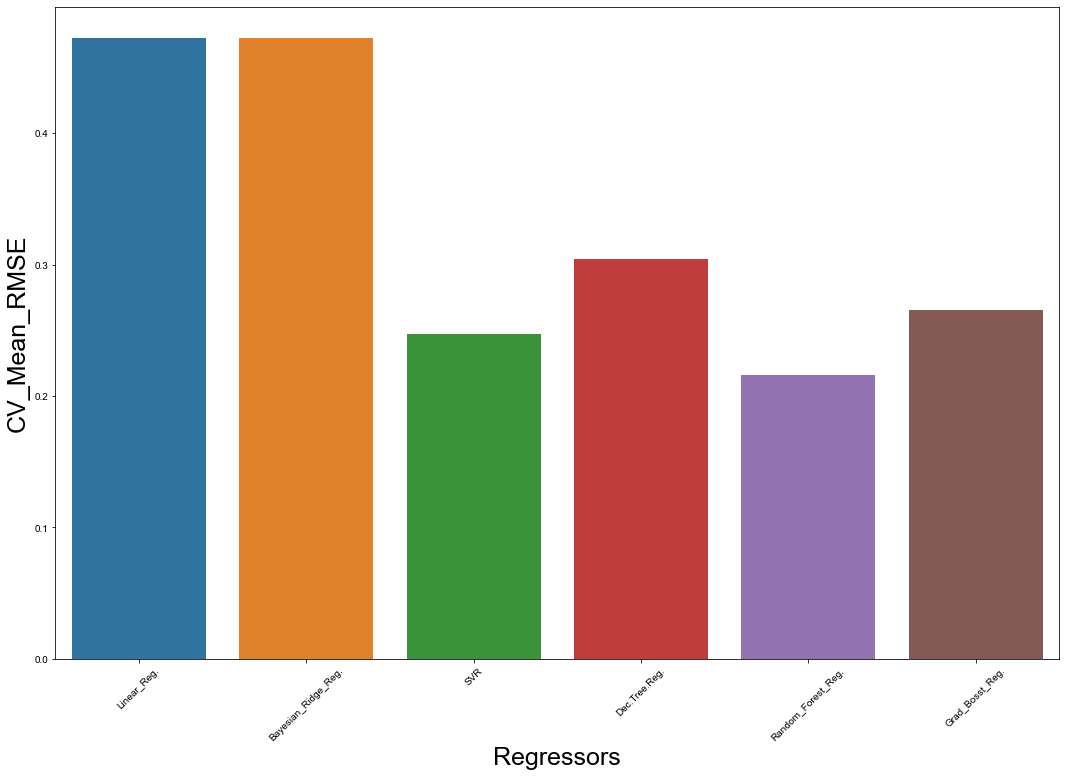

In [74]:
plt.figure(figsize = (18,12))
sns.barplot(final_cv_score['Regressors'],final_cv_score['RMSE_mean'])
sns.set(font_scale = 2)
plt.xlabel('Regressors', fontsize = 25)
plt.ylabel('CV_Mean_RMSE', fontsize = 25)
plt.xticks(rotation=45)
plt.show()

In [75]:
final_cv_score

Regressors  RMSE_mean  RMSE_std
0          Linear_Reg.   0.472688  0.010529
1  Bayesian_Ridge_Reg.   0.472688  0.010525
2                  SVR   0.246907  0.008715
3        Dec.Tree.Reg.   0.304255  0.008514
4   Random_Forest_Reg.   0.215938  0.009566
5      Grad_Bosst_Reg.   0.265680  0.009006